In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, IntSlider
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [52]:
n = 4
m = 1000
x = np.array([-1/2, -1/6, 1/6, 1/2])
y = np.array([1/4, 1/30, 1/30, 1/4])

In [53]:
## Helper functions

def relu(x):
    return np.maximum(0, x)

def indicator(condition):
    return condition.astype(int)

In [54]:
# 2-Lyaer ReLu Neural Network

def twoLayerReluNet(alpha_m, a, w, b, x):
    return 1/alpha_m * np.sum([[a[j] * relu(w[j] * x + b[j])] for j in range (m)])

In [55]:
## We use the following to fix the values of gamma, gamma_prime and alpha_m
gamma = 3/2
gamma_prime = -1/2

alpha_m = m**(gamma - gamma_prime)
kappa = m**(-gamma)
kappa_prime = m**(-gamma_prime)

beta_1m = math.sqrt(kappa*kappa_prime*alpha_m)
beta_2m = math.sqrt((kappa/kappa_prime)*alpha_m)

In [56]:
## Typical parameter gradients

def gradient_flow(a,w,b):
    grad_a = -(1/n) * np.sum([[(1/alpha_m) * relu((w*x[i])+b) * gradRiskwrtFunction(a,w,b,i)] for i in range(n)], axis=0).reshape(m)
    grad_w = -(1/n) * np.sum([[(1/alpha_m) * a*x[i] * indicator(w*x[i]+b > 0) * gradRiskwrtFunction(a,w,b,i)] for i in range(n)], axis=0).reshape(m)
    grad_b = -(1/n) * np.sum([[(1/alpha_m) * a * indicator(w*x[i]+b > 0) * gradRiskwrtFunction(a,w,b,i)] for i in range(n)], axis=0).reshape(m)
    return grad_a, grad_w, grad_b

def gradRiskwrtFunction(a,w,b,i):
    return twoLayerReluNet(alpha_m, a, w, b, x[i]) - y[i]


In [7]:
## Normalized parameter gradients

def normalised_gradient_flow(a,w,b):
    grad_a = - kappa_prime * (1/n) * np.sum([[kappa * relu((w*x[i])+b) * gradRiskwrtFunction(a,w,b,i)] for i in range(n)], axis=0).reshape(m)
    grad_w = - kappa_prime * np.sum([[kappa * a*x[i] * indicator(w*x[i]+b > 0) * gradRiskwrtFunction(a,w,b,i)] for i in range(n)], axis=0).reshape(m)
    grad_b = - kappa_prime * np.sum([[kappa * a * indicator(w*x[i]+b > 0) * gradRiskwrtFunction(a,w,b,i)] for i in range(n)], axis=0).reshape(m)
    return grad_a, grad_w, grad_b

def normalised_gradRiskwrtFunction(a,w,b,i):
    return kappa * np.sum([[a[j] * relu((w[j]*x[i])+b[j]) - y[i]] for j in range(m)], axis=0)

def normalise_param(a,w,b,t):
    return a/beta_1m, w/beta_2m, b/beta_2m, t/(beta_1m * beta_2m)

In [63]:
def gradient_descent(step_size, steps):
    
    a = np.random.normal(loc=0, scale=beta_1m, size=(m))
    w = np.random.normal(loc=0, scale=beta_2m, size=(m))
    b = np.random.normal(loc=0, scale=beta_2m, size=(m))

    a_values = []
    w_values = []
    b_values = []

    #for n in range(math.ceil(time/step_size)):
    for n in range(steps): 
        grad_a, grad_w, grad_b = gradient_flow(a,w,b)
        a = a + step_size * grad_a
        w = w + step_size * grad_w
        b = b + step_size * grad_b

        # Save the current values of a, w, and b
        a_values.append(a.copy())
        w_values.append(w.copy())
        b_values.append(b.copy())

    return a_values, w_values, b_values

def gradient_descent_symmetric(step_size, steps):
    
    a = np.random.normal(loc=0, scale=beta_1m, size=math.ceil(m/2))
    w = np.random.normal(loc=0, scale=beta_2m, size=math.ceil(m/2))
    b = np.random.normal(loc=0, scale=beta_2m, size=math.ceil(m/2))

    a = np.concatenate((a, a))
    w = np.concatenate((w, -w))
    b = np.concatenate((b, b))

    a_values = []
    w_values = []
    b_values = []

    #for n in range(math.ceil(time/step_size)):
    for n in range(steps): 
        grad_a, grad_w, grad_b = gradient_flow(a,w,b)
        a = a + step_size * grad_a
        w = w + step_size * grad_w
        b = b + step_size * grad_b

        # Save the current values of a, w, and b
        a_values.append(a.copy())
        w_values.append(w.copy())
        b_values.append(b.copy())

    return a_values, w_values, b_values

def gradient_descent_normalised(step_size, time):
    
    a = np.random.normal(loc=0, scale=beta_1m**2, size=(m))
    w = np.random.normal(loc=0, scale=beta_2m**2, size=(m))
    b = np.random.normal(loc=0, scale=beta_2m**2, size=(m))

    a_bar, w_bar, b_bar, t_bar = normalise_param(a,w,b,time)

    for n in range(math.ceil(t_bar/step_size)):
        
        grad_a, grad_w, grad_b = normalised_gradient_flow(a_bar,w_bar,b_bar)
        a_bar = a_bar + step_size * grad_a
        w_bar = w_bar + step_size * grad_w
        b_bar = b_bar + step_size * grad_b

    return a_bar*beta_1m, w_bar*beta_2m, b_bar*beta_2m  # THIS NEEDS TO BE RENORMALISED
        
# Assuming beta_1m, beta_2m, m, and gradient_flow are defined
n_steps = 200000
a_values_sym, w_values_sym, b_values_sym = gradient_descent_symmetric(4000, n_steps)

# Convert lists to arrays for easier saving and plotting
a_values_sym = np.array(a_values_sym)
w_values_sym = np.array(w_values_sym)
b_values_sym = np.array(b_values_sym)

# Save the arrays to disk
np.save('a_values_symmetric.npy', a_values_sym)
np.save('w_values_symmetric.npy', w_values_sym)
np.save('b_values_symmetric.npy', b_values_sym)

print("Done Symmetric")

a_values, w_values, b_values = gradient_descent(4000, n_steps)

# Convert lists to arrays for easier saving and plotting
a_values = np.array(a_values)
w_values = np.array(w_values)
b_values = np.array(b_values)

# Save the arrays to disk
np.save('a_values.npy', a_values)
np.save('w_values.npy', w_values)
np.save('b_values.npy', b_values)

Done Symmetric


In [70]:
# Load the arrays from the .npy files
a_values = np.load('a_values_symmetric.npy')
w_values = np.load('w_values_symmetric.npy')
b_values = np.load('b_values_symmetric.npy')

# Define the range of x
x_graph = np.linspace(-0.5, 0.5, 800)
y_graph = np.zeros(len(x_graph))

# Define the function to plot the values at a given index
def plot_values(index):
    a = a_values[index]
    w = w_values[index]
    b = b_values[index]

    # Compute the corresponding y values
    for i in range(len(x_graph)):
        y_graph[i] = twoLayerReluNet(alpha_m,a,w,b,x_graph[i])

    # Plot the function
    plt.scatter(x, y, c='orange', alpha=0.5)
    plt.plot(x_graph, y_graph)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.xlim(-0.6, 0.6)
    plt.ylim(-0.01, 0.3)
    plt.show()

# Create an interactive slider
interact(plot_values, index=IntSlider(min=0, max=len(a_values)-1, step=1, value=0))

# a = np.full(m, 4)
# w = np.full(m, 0.1)
# b = np.full(m, 0.1)


# # Compute the corresponding y values
# for i in range(len(x_graph)):
#     y_graph[i] = twoLayerReluNet(alpha_m,a,w,b,x_graph[i])

# # Plot the function
# plt.scatter(x, y, c='orange', alpha=0.5)
# plt.plot(x_graph, y_graph)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.grid(True)
# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.01, 0.3)
# plt.show()

interactive(children=(IntSlider(value=0, description='index', max=199999), Output()), _dom_classes=('widget-in…

<function __main__.plot_values(index)>

-0.0005294969513511479 -0.0004946346475583757
0.10269056733290817 0.10272959477266967
0.13303110322313055 0.13315445836942422
0.139874032724407 0.140021464569582
0.14124722658421235 0.14141915551806322
0.14150448351101524 0.14170355009411367
0.14154032778368508 0.14176814424995515
0.14153189539981975 0.14178994730650635
0.14151393422736455 0.14180390328150794
0.14149321863964523 0.1418169156061604
0.14147094229582488 0.14183036210067815
0.14144724712654902 0.14184458457653557
0.14142205847047642 0.14185971181691417
0.14139524878260157 0.14187583252631908
0.1413666729288333 0.14189303168499173
0.14133617448929586 0.14191139802326871
0.14130358633093013 0.14193102584867495
0.1412687300119758 0.14195201578788214
0.14123141491031366 0.1419744753409497
0.14119143724686117 0.1419985194260933
0.14114857903342667 0.1420242709522487
0.14110260601850774 0.1420518796974023
0.14105326426143805 0.14208143916305152
0.14100030730108362 0.1421131284406201
0.14094343528614986 0.14214711290217744
0.1408

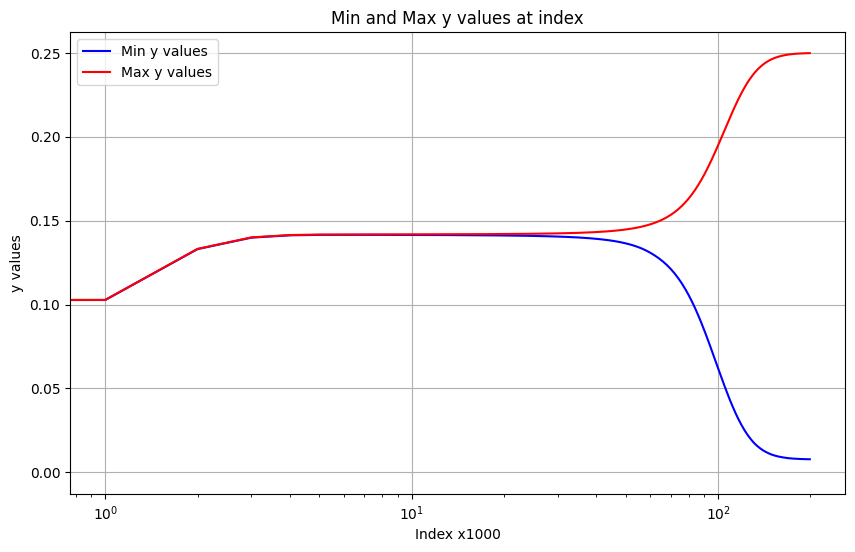

In [74]:
# Define the function to plot the values at a given index
def get_values(index):
    a = a_values[index]
    w = w_values[index]
    b = b_values[index]
    
    y_graph = np.zeros((int)(400))
    # Compute the corresponding y values
    for i in range(len(x_graph)):
        y_graph[i] = twoLayerReluNet(alpha_m,a,w,b,x_graph[i])

    print(np.min(y_graph), np.max(y_graph))
    return np.min(y_graph), np.max(y_graph)


x_graph = np.linspace(-0.5, 0.5, 400)
# Initialize an array to store y values
min_y_values = np.zeros((int)(n_steps/1000))
max_y_values = np.zeros((int)(n_steps/1000))
for n in range((int)(n_steps/1000)):
    min_y_values[n], max_y_values[n] = get_values(n*1000)

# Create an array of indices
indices = np.arange(n_steps/1000)

# Plot the min and max values
plt.figure(figsize=(10, 6))
plt.plot(indices, min_y_values, color='blue', label='Min y values')
plt.plot(indices, max_y_values, color='red', label='Max y values')
plt.xscale('log')
plt.xlabel('Index x1000')
plt.ylabel('y values')
plt.title('Min and Max y values at index')
plt.legend()
plt.grid(True)
plt.show()

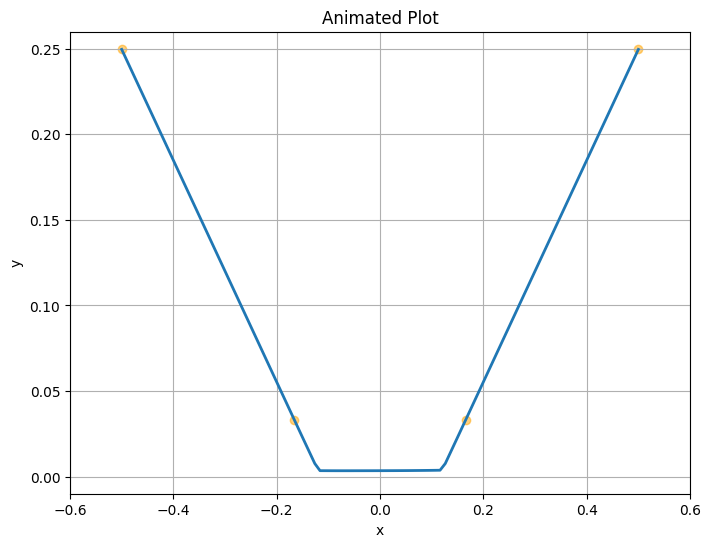

In [26]:
# Assuming a_values, w_values, and b_values are already loaded
a_values = np.load('a_values.npy')
w_values = np.load('w_values.npy')
b_values = np.load('b_values.npy')

# Example x values (replace with your actual x values)
x_graph = np.linspace(-0.5, 0.5, 100)
y_graph = np.zeros(len(x_graph))


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.plot([], [], lw=2)

# Set limits for x and y axes
ax.scatter(x, y, c='orange', alpha=0.5)
ax.set_xlim(-0.6, 0.6)  # Set x-axis limits
ax.set_ylim(-0.01, 0.26)  # Set y-axis limits
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Animated Plot')
ax.grid(True)

# Initialization function to set up the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function to update the plot
def animate(i):
    a = a_values[i*1000]
    w = w_values[i*1000]
    b = b_values[i*1000]
    
    # Compute the corresponding y values
    for j in range(len(x_graph)):
        y_graph[j] = twoLayerReluNet(alpha_m,a,w,b,x_graph[j])
    
    line.set_data(x_graph, y_graph)
    return line,

# Create the animation
anim = FuncAnimation(fig, animate, init_func=init, frames=(int)(len(a_values)/1000), interval=1, blit=True, repeat=True, repeat_delay=100)

# Save the animation
anim.save('animation.html', writer='html')
